In [5]:
# use "orca" environment. Install dependencies of orca, robot_io, and rtx_on_taco in order
from datetime import datetime
import time
import cv2
import hydra
import torch
import tensorflow_hub as hub
from IPython import display
from PIL import Image
import numpy as np
# import rlds
import tensorflow_datasets as tfds
import tensorflow as tf
import sys
from pathlib import Path
import os
import jax
import collections
import click
import matplotlib.pyplot as plt

from robot_io.utils.utils import quat_to_euler
# from calvin_env.utils.utils import angle_between_angles
from hulc2.wrappers.panda_rtx_wrapper import PandaRTXWrapper
from hulc2.evaluation.utils import imshow_tensor
from orca.utils.pretrained_utils import ORCAModel

In [2]:
checkpoint_dir = "/home/huang/hcg/projects/orca/data/final_diffusion_model"
model = ORCAModel.load_pretrained(checkpoint_dir)
statistics = statistics = ORCAModel.load_dataset_statistics(checkpoint_dir, "taco_play")

2023-12-10 23:53:24.038770: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.7 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/export/home/huang/mambaforge/envs/orca/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `mod

In [6]:
from pathlib import Path
data_dir = Path("/export/home/huang/orca/turn_on_the_green_light_test")

In [4]:
# load episode
def load_episode(data_dir, start_id, end_id):
    obs_list = []
    for id in range(start_id, end_id):
        id_zfill = str(id).zfill(7)
        name = "episode_{}.npz".format(id_zfill)
        obs_path = Path(data_dir) / name
        obs = np.load(obs_path, allow_pickle=True)
        obs = dict(obs)
        obs_list.append(obs)
    return obs_list

ep_start_end_ids_path = data_dir / "ep_start_end_ids.npy"
ep_start_end_ids = np.load(ep_start_end_ids_path)
EP_ID = 0
obs_list = load_episode(data_dir, ep_start_end_ids[EP_ID, 0], ep_start_end_ids[EP_ID, 1])
print(obs_list[0].keys())
print(obs_list[0]['rgb_static'].shape)
print(obs_list[0]['robot_obs'].shape)

dict_keys(['actions', 'rel_actions_world', 'rel_actions_gripper', 'robot_obs', 'rgb_static', 'depth_static', 'rgb_gripper', 'depth_gripper'])
(434, 578, 3)
(15,)


Text(0.5, 1.0, 'gripper camera goal')

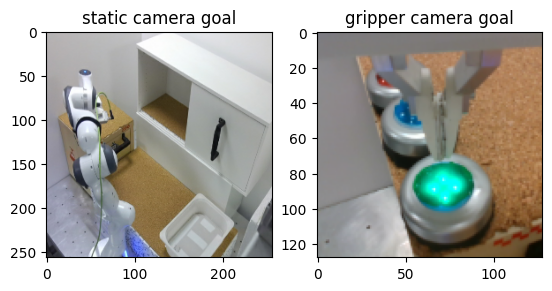

In [16]:
goal_obs = obs_list[-1]
goal_image = goal_obs["rgb_static"]
goal_image_wrist = goal_obs["rgb_gripper"]

goal_image = cv2.resize(goal_image, (256, 256))
goal_image_wrist = cv2.resize(goal_image_wrist, (128, 128))
fig, ax = plt.subplots(1, 2)
ax[0].imshow(goal_image)
ax[0].set_title("static camera goal")
ax[1].imshow(goal_image_wrist)
ax[1].set_title("gripper camera goal")


In [17]:
goal_image = goal_image[None, ...]
goal_image_wrist = goal_image_wrist[None, ...]
task_image = model.create_tasks(goals={"image_0": goal_image, "image_1": goal_image_wrist})
task_lang = model.create_tasks(texts=["turn on the green light"])
policy_fn = jax.jit(model.sample_actions)

In [18]:
task = task_image

In [44]:
class ExpWeightedAverage:
    def __init__(self, pred_horizon: int, exp_weight: int = 0):
        self.pred_horizon = pred_horizon
        self.exp_weight = exp_weight
        self.act_history = collections.deque(maxlen=self.pred_horizon)

    def get_action(self, actions: np.ndarray) -> np.ndarray:
        assert len(actions) >= self.pred_horizon
        self.act_history.append(actions[:self.pred_horizon])
        num_actions = len(self.act_history)

        curr_act_preds = np.stack([
            pred_actions[i] for (i, pred_actions) in zip(range(num_actions - 1, -1, -1), self.act_history)
        ])

        exponents = np.exp(-self.exp_weight * np.arange(num_actions)) 
        weights = exponents / np.sum(exponents)
        action = np.sum(weights[:, None] * curr_act_preds, axis=0)
        return action

In [1]:
horizon = 2
pred_horizon = 4
exp_weight = 1
action_chunking = 4

tf_observation_list = []
gt_actions = []
pred_actions = []
resized_images = []
resized_images_gripper = []

obs_deque = collections.deque(maxlen=horizon)
obs_deque_wrist = collections.deque(maxlen=horizon)
ewa_action = ExpWeightedAverage(pred_horizon, exp_weight=exp_weight)
observations = {
    "image_0": np.zeros((1, horizon, 256, 256, 3), dtype=np.uint8),  # batch, horizon, width, height, channels,
    # optionally add "image_1": np.zeros((1, 2, 128, 128,3), dtype=np.uint8) for wrist camera
    "image_1": np.zeros((1, horizon, 128, 128, 3), dtype=np.uint8),  # for wrist camera
    "pad_mask": np.array([[True, True]])
}

chunk_step_count = 0
for obs in obs_list:
    image = obs['rgb_static']
    image = cv2.resize(image, (256, 256))
    image_wrist = obs['rgb_gripper']
    image_wrist = cv2.resize(image_wrist, (128, 128))
    # fill the deque with the first observation
    obs_deque.append(image)
    obs_deque.append(image)
    obs_deque_wrist.append(image_wrist)
    obs_deque_wrist.append(image_wrist)

    images = np.stack([x for x in obs_deque])
    images_wrist = np.stack([x for x in obs_deque_wrist])
    
    if images.shape[0] == horizon and images_wrist.shape[0] == horizon:
        print(f"{chunk_step_count=}")
        resized_images.append(image)
        resized_images_gripper.append(image_wrist)
        if chunk_step_count == 0:
            observations["image_0"] = images[None, ...]
            observations["image_1"] = images_wrist[None, ...]
            actions = policy_fn(observations, task, rng=jax.random.PRNGKey(0))
            pred_action = (actions[0] * np.array(statistics['action']['std'])) + np.array(statistics['action']['mean'])
            pred_action_np = np.asarray(pred_action)
            pred_action_torch = torch.from_numpy(pred_action_np)
            print(pred_action_torch.shape)
            pred_action_torch[:, -1] = pred_action_torch[:, -1] * 2. - 1.
            pred_action_np = pred_action_torch.numpy()
            pred_action_np_chunk = pred_action_np.copy()
            print(f"{pred_action_np_chunk=}")
            pred_action_np = ewa_action.get_action(pred_action_np)
            pred_actions.append(pred_action_np)
            gt_actions.append(obs["rel_actions_world"])
            if chunk_step_count < action_chunking:
                chunk_step_count += 1
        else:
            pred_actions.append(pred_action_np_chunk[chunk_step_count])
            gt_actions.append(obs["rel_actions_world"])
            chunk_step_count += 1
        if chunk_step_count == action_chunking:
            chunk_step_count = 0
            
        print(pred_action_np)

NameError: name 'collections' is not defined

In [2]:
image_sampled_rate = 10
gt_actions = np.array(gt_actions)
pred_actions = np.array(pred_actions)
stacked = np.concatenate(resized_images[::image_sampled_rate], axis=1)
stacked_gripper = np.concatenate(resized_images_gripper[::image_sampled_rate], axis=1)

NameError: name 'np' is not defined

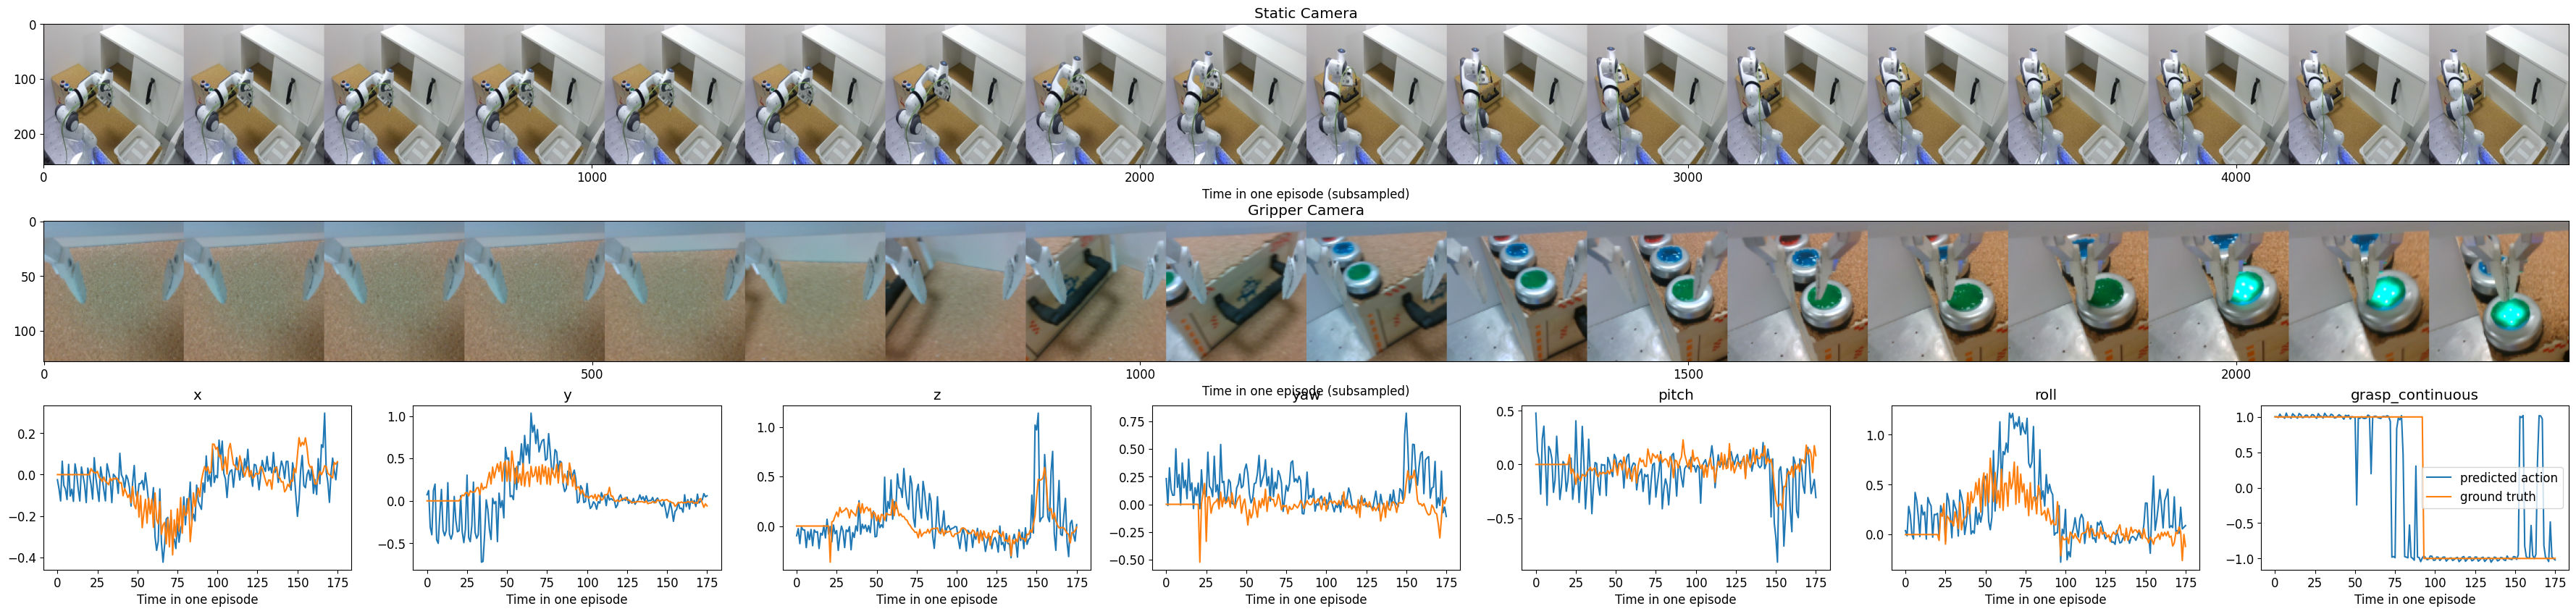

In [53]:
action_order = ['x', 'y', 'z', 'yaw', 'pitch', 'roll', 'grasp_continuous']

figure_layout = [
    ['image'] * len(action_order),
    ['image_gripper'] * len(action_order),
    action_order
]

plt.rcParams.update({'font.size': 12})


# fig, axs = plt.subplots(1, len(action_name_to_values_over_time))
fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

for action_dim, action_name in enumerate(action_order):
  axs[action_name].plot(pred_actions[:, action_dim], label='predicted action')
  axs[action_name].plot(gt_actions[:, action_dim], label='ground truth')

  axs[action_name].set_title(action_name)
  axs[action_name].set_xlabel('Time in one episode')

axs['image'].imshow(stacked)
axs['image'].set_xlabel('Time in one episode (subsampled)')
axs['image'].set_title(f'Static Camera')

axs['image_gripper'].imshow(stacked_gripper)
axs['image_gripper'].set_xlabel('Time in one episode (subsampled)')
axs['image_gripper'].set_title(f'Gripper Camera')

plt.legend()